## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.2 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image

## Prepare the data

In [ ]:
%cd /content/drive/MyDrive/LuanVan/vit_stone/

/content/drive/MyDrive/LuanVan/vit_stone


In [ ]:
import glob
kidney_stone = glob.glob('/content/drive/MyDrive/LuanVan/dataset/Kidney_stone/*.*')
normal = glob.glob('/content/drive/MyDrive/LuanVan/dataset/Normal/*.*')
#print(kidney_stone)
data = []
labels = []

for i in kidney_stone:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    #print(image)
    image=np.array(image)
    data.append(image)
    labels.append(0)
    
for i in normal:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(1)

data = np.array(data)
labels = np.array(labels)
#print(data)
print(labels)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

[0 0 0 ... 1 1 1]


## Configure the hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 1000
image_size = 224  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [ ]:
X_train.shape

(1307, 224, 224, 3)

In [ ]:
X_test.shape

(327, 224, 224, 3)

In [ ]:
y_train

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
y_test

In [ ]:
X_test.shape

(327, 280, 280, 3)

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
#data_augmentation.layers[0].adapt(x_train)
data_augmentation.layers[0].adapt(X_train)

## Implement multilayer perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

In [ ]:
import cv2

In [ ]:
from matplotlib import pyplot

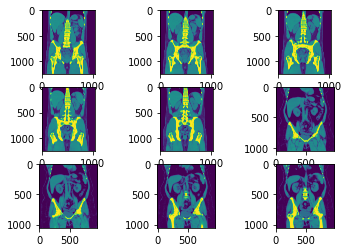

In [ ]:
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = '/content/drive/MyDrive/LuanVan/vit_stone/vit/data/images_stone/Train/Normal/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'Normal' + str(i+1) + '.png'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [ ]:
from keras.preprocessing import image
datagen = image.ImageDataGenerator(rescale=1.0/255.0)

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


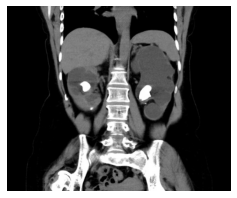

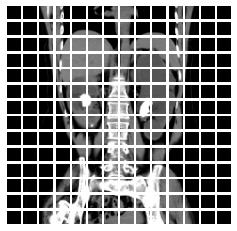

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
#image = x_train[np.random.choice(range(x_train.shape[0]))]
#print(image)
img=plt.imread("/content/drive/MyDrive/LuanVan/vit_stone/kidney_stone13.jpg")
#print(img)
plt.imshow(img.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer



In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model



In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=projection_dim, 
            dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [ ]:
input_shape=(224,224,3)
num_classes=2

In [ ]:
model = create_vit_classifier()

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
       keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
       keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"), ],)

In [ ]:
history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
    )

In [ ]:
results = model.evaluate(X_test, y_test)

print('Test loss: {:4f}'.format(results[0]))
print('Test accuracy: {:4f}'.format(results[1]))

11/11 [==============================] - 1s 49ms/step - loss: 0.3071 - accuracy: 0.9021 - top-5-accuracy: 1.0000
Test loss: 0.307070
Test accuracy: 0.902141


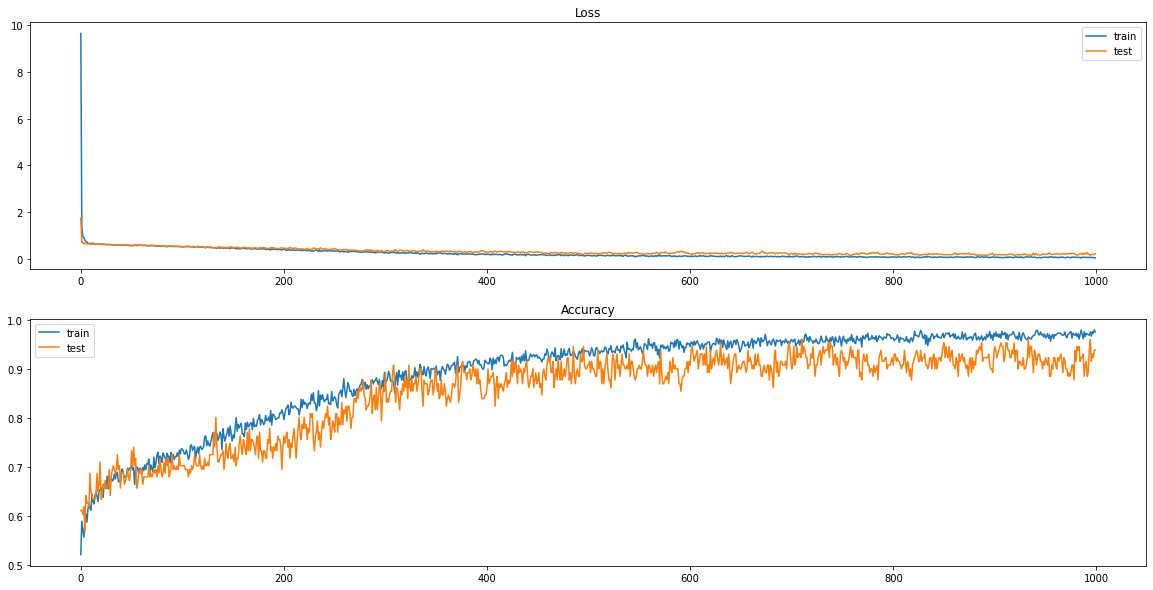

In [ ]:
#16x16
# plot loss và accuracy
pyplot.figure(figsize=(20,10))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
y_hat = model.predict(X_test)
y_pred = np.argmax(y_hat, axis=1)
#y_test_label =  np.argmax(y_test, axis=1)

y_test_label= y_test.reshape(-1, 1)
#print(y_test_label)
#print(y_pred)
# Tính accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_label, y_pred)
print('Accuracy: %f' % accuracy)
# Tính precision tp / (tp + fp)
precision = precision_score(y_test_label, y_pred, average='macro')
print('Precision: %f' % precision)
# Tính recall: tp / (tp + fn)
recall = recall_score(y_test_label, y_pred, average='macro')
print('Recall: %f' % recall)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_label, y_pred, average='macro')
print('F1 score: %f' % f1)
# Tính Area under ROC
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print('ROC AUC: %f' % auc)
# Tính confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test_label, y_pred)
print('Confusion matrix:')
print(cnf_matrix)
#print('\nAccuracy:', np.diagonal(cnf_matrix).sum()/cnf_matrix.sum())

normalized_confusion_matrix = cnf_matrix/cnf_matrix.sum(axis = 1, keepdims = True)
print('\nConfusion matrix (with normalizatrion:)')
print(normalized_confusion_matrix)

Accuracy: 0.902141
Precision: 0.920550
Recall: 0.889670
F1 score: 0.897580
ROC AUC: 0.889670
Confusion matrix:
[[113  30]
 [  2 182]]

Confusion matrix (with normalizatrion:)
[[0.79020979 0.20979021]
 [0.01086957 0.98913043]]


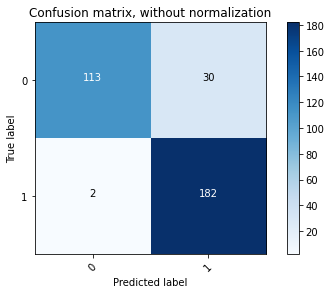

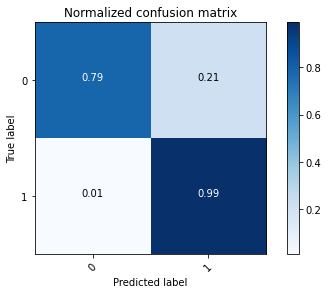

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#kiểm tra với ảnh có sỏi

In [ ]:
from keras.preprocessing import image

In [ ]:
path="/content/drive/MyDrive/LuanVan/data_kidney_stone_detection/images/test/Kidney_stone10.png"
img=image.load_img(path, target_size=(224,224))

img=image.img_to_array(img)/255
img=np.array([img])
img.shape

(1, 224, 224, 3)

In [ ]:
y_actual_1 = np.argmax(model.predict(img))
y_actual_1
if(y_actual_1==0):
  print ("Actual: Stone")
else:
  print ("Actual: Normal")


Actual: Stone


In [ ]:
from IPython.display import Image, clear_output

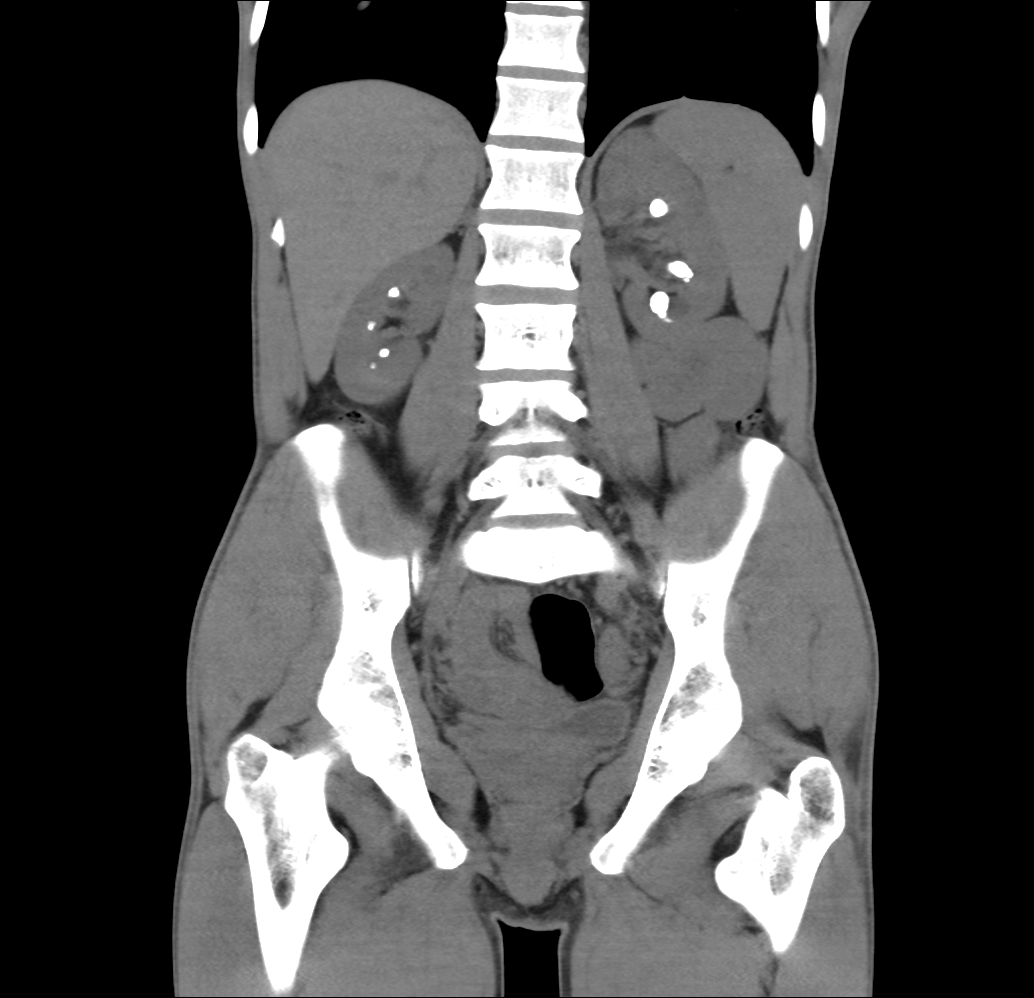

In [ ]:
Image(filename='/content/drive/MyDrive/LuanVan/data_kidney_stone_detection/images/test/Kidney_stone10.png', width=240)

#ktra với ảnh không có sỏi

In [ ]:
path_1="/content/drive/MyDrive/LuanVan/dataset/Normal/1.3.46.670589.33.1.63684832005507252400001.4814015771922220890.png"
img_1=image.load_img(path_1, target_size=(224,224))

img_1=image.img_to_array(img_1)/255
img_1=np.array([img_1])
img_1.shape

(1, 224, 224, 3)

In [ ]:
y_actual_1 = np.argmax(model.predict(img))
y_actual_1
if(y_actual_1==0):
  print ("Actual: Stone")
else:
  print ("Actual: Normal")


Actual: Normal


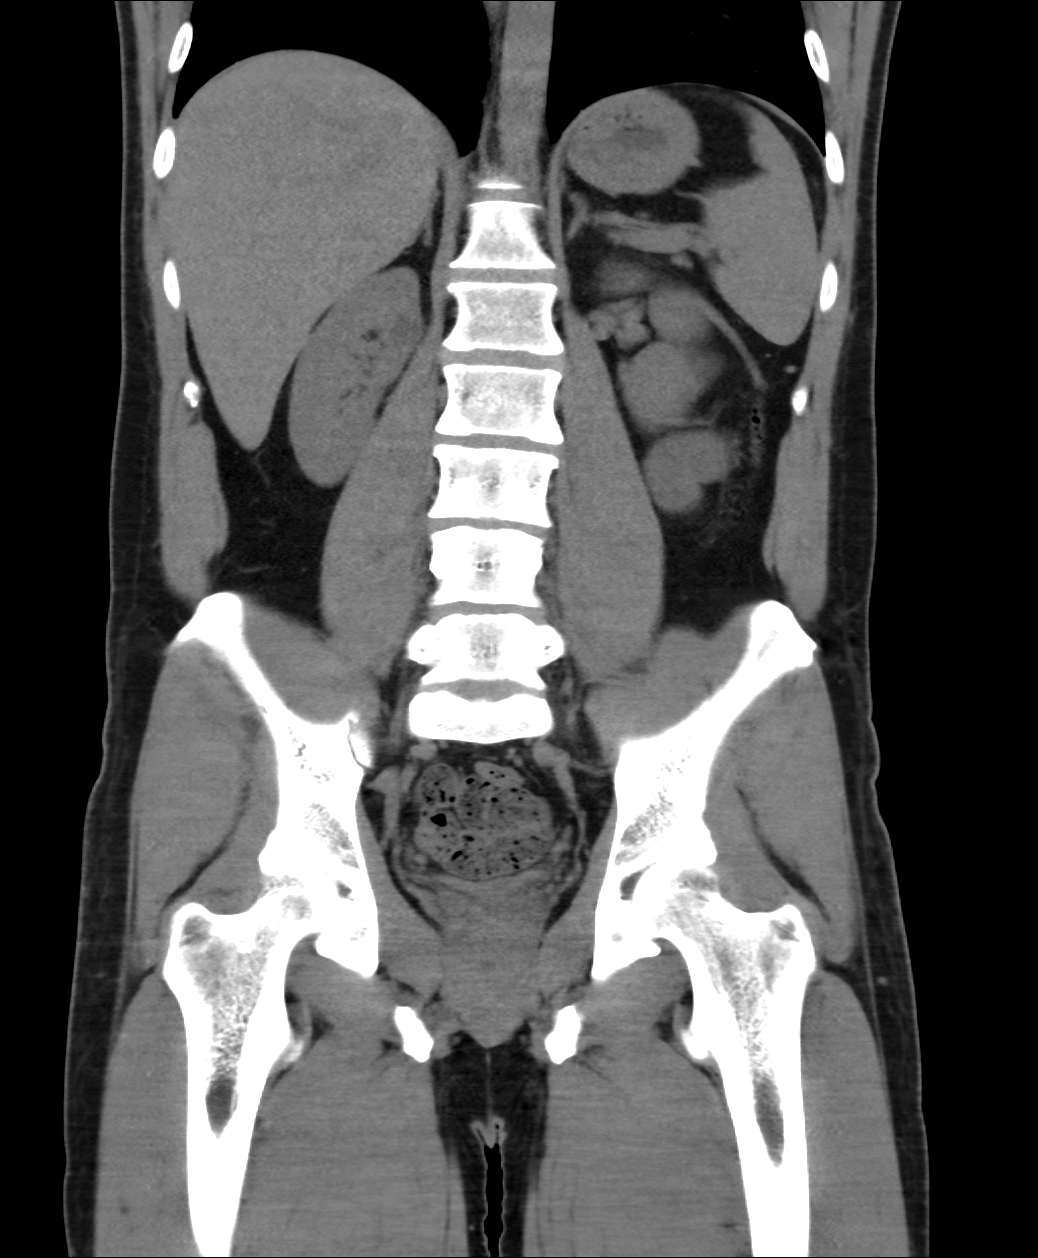

In [ ]:
Image(filename='/content/drive/MyDrive/LuanVan/dataset/Normal/1.3.46.670589.33.1.63684832005507252400001.4814015771922220890.png', width=240)